<a href="https://colab.research.google.com/github/vivinRajagopalan/prophet-challenge/blob/main/forecasting_net_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [2]:
# Install the required libraries
!pip install prophet

In [3]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [4]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()


# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-4-eea7a1f07523>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [5]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


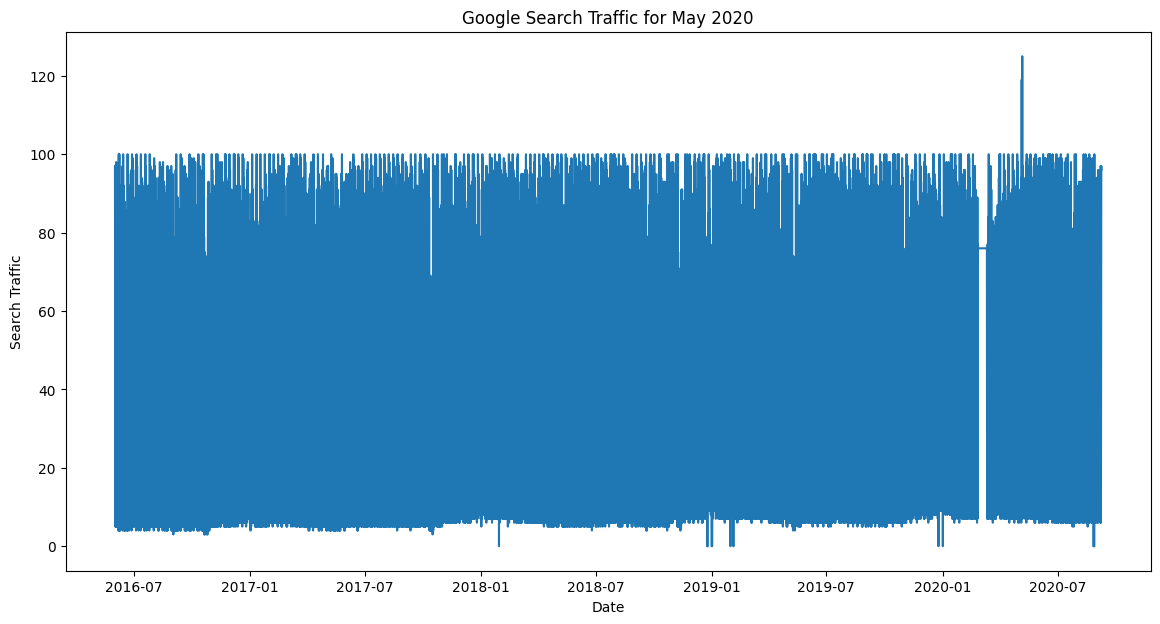

In [6]:
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends.loc['2020-05']

# Plot to visualize the data for May 2020
import matplotlib.pyplot as plt

# Plot the search data for May 2020
plt.figure(figsize=(14, 7))
plt.plot(df_mercado_trends['Search Trends'])
plt.title('Google Search Traffic for May 2020')
plt.xlabel('Date')
plt.ylabel('Search Traffic')
plt.show()



#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [7]:
# Calculate the sum of the total search traffic for May 2020
total_may_2020_traffic = df_mercado_trends['Search Trends'].sum()

# View the traffic_may_2020 value
monthly_median_traffic = df_mercado_trends.resample('M').sum()['Search Trends'].median()

print(f"Total search traffic for May 2020: {total_may_2020_traffic}")
print(f"Monthly median search traffic: {monthly_median_traffic}")

# Determine if there was an increase in May 2020
traffic_increase = total_may_2020_traffic > monthly_median_traffic
print(f"Did the Google search traffic increase in May 2020? {'Yes' if traffic_increase else 'No'}")


Total search traffic for May 2020: 1785865
Monthly median search traffic: 35172.5
Did the Google search traffic increase in May 2020? Yes


In [8]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic = df_mercado_trends.resample('M').sum()['Search Trends']
median_monthly_traffic1 = monthly_traffic.median()

monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum()
median_monthly_traffic2 = monthly_traffic['Search Trends'].median()

# Viewing the median_monthly_traffic value
print(median_monthly_traffic1)

# View the median_monthly_traffic value
print(median_monthly_traffic2)

35172.5
35172.5


In [9]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
may_2020_traffic = df_mercado_trends.loc['2020-05']['Search Trends'].sum()
traffic_increase = may_2020_traffic > median_monthly_traffic2
print(f"Did the Google search traffic increase in May 2020? {'Yes' if traffic_increase else 'No'}")

Did the Google search traffic increase in May 2020? Yes


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

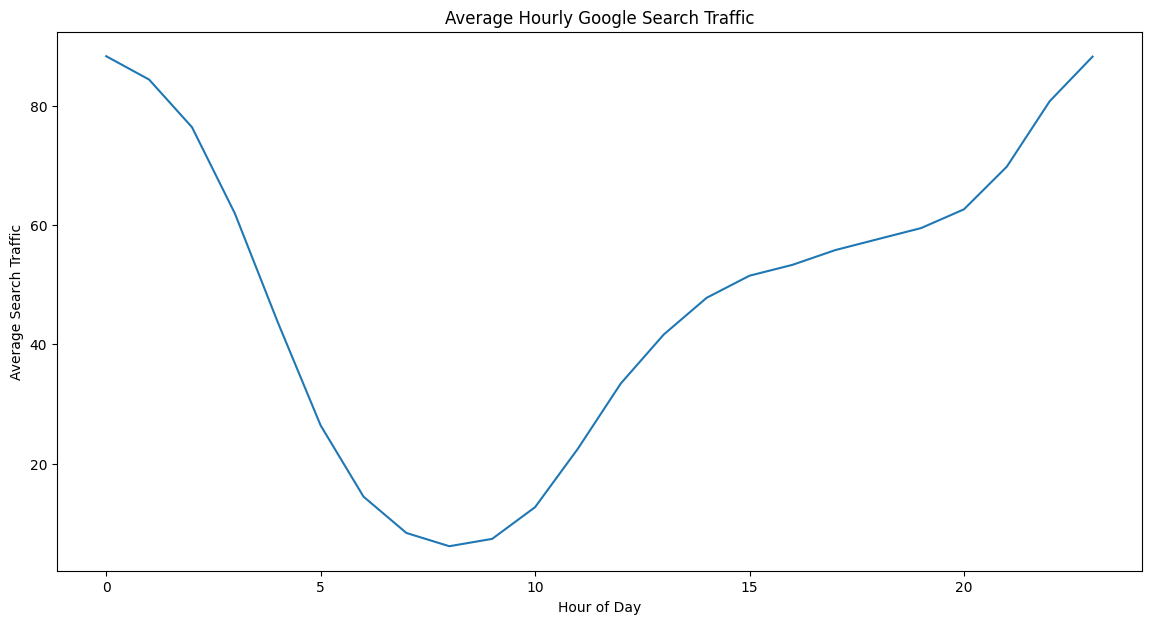

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

plt.figure(figsize=(14, 7))
plt.plot(hourly_avg_traffic['Search Trends'])
plt.title('Average Hourly Google Search Traffic')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Traffic')
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

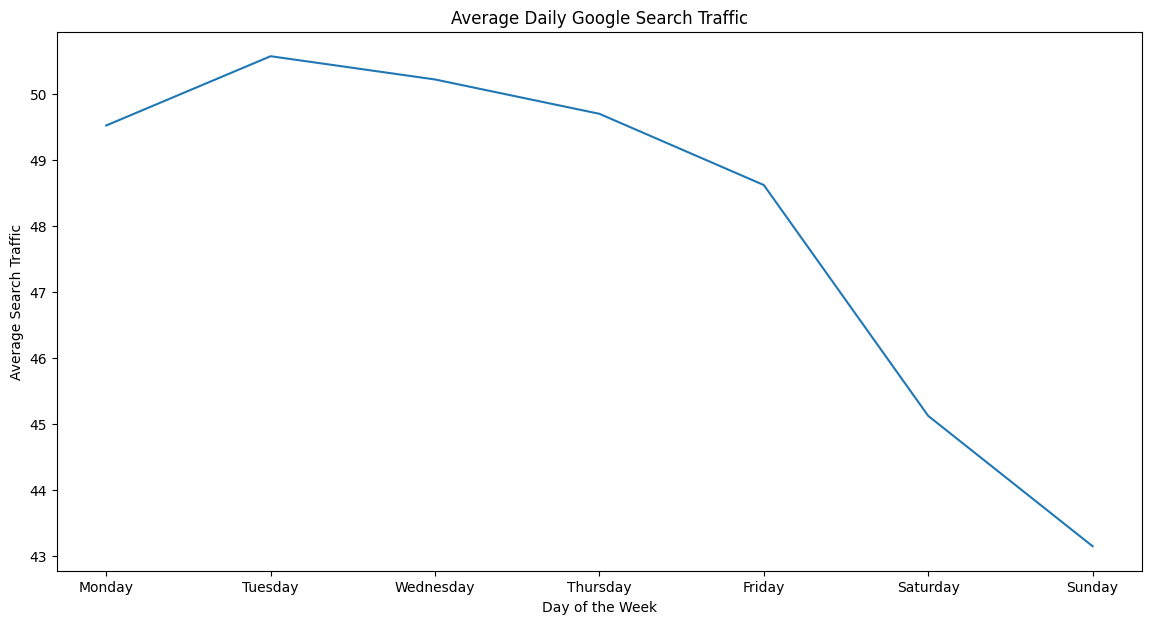

In [11]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# Ensure the index is a datetime index
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)

# Group the hourly search data to plot the average traffic by the day of week
daily_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_traffic['Search Trends'])
plt.title('Average Daily Google Search Traffic')
plt.xlabel('Day of the Week')
plt.ylabel('Average Search Traffic')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

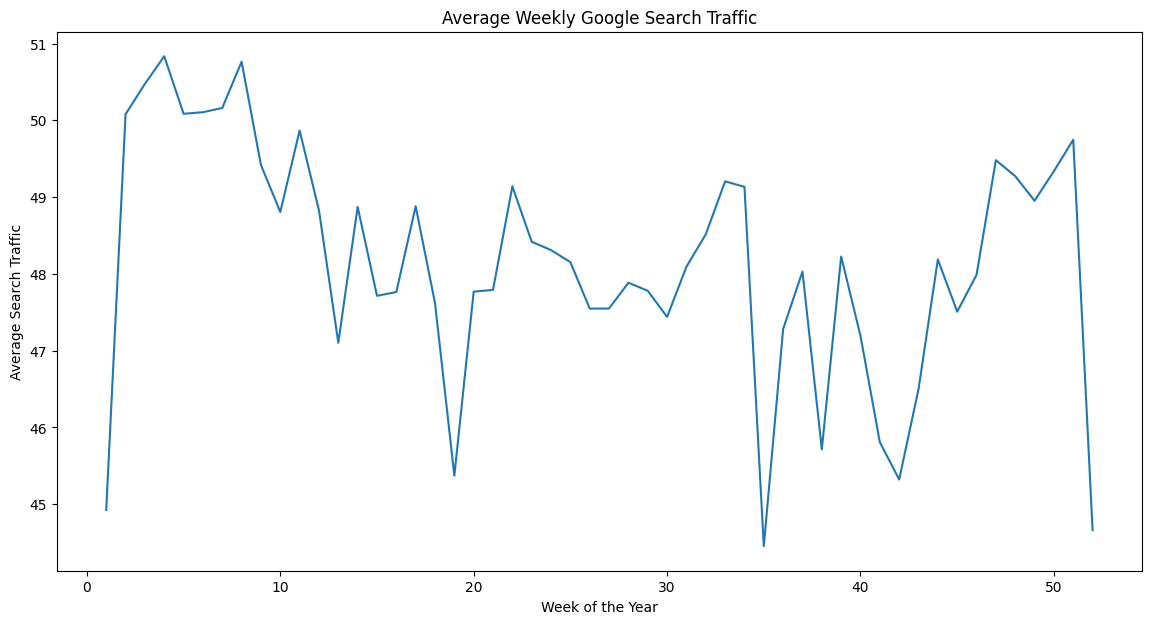

In [12]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_avg_traffic['Search Trends'])
plt.title('Average Weekly Google Search Traffic')
plt.xlabel('Week of the Year')
plt.ylabel('Average Search Traffic')
plt.show()


##### Answer the following question:

 **Question:** Are there any time based trends that you can see in the data?

**Answer:**

By analyzing these time-based trends, I conclude that:

Hourly: People are most active in searching during typical start and end of workday hours.
Daily: Search activity is higher during weekdays compared to weekends.
Weekly: Certain weeks, particularly those around holidays and significant events, show increased search traffic.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [13]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


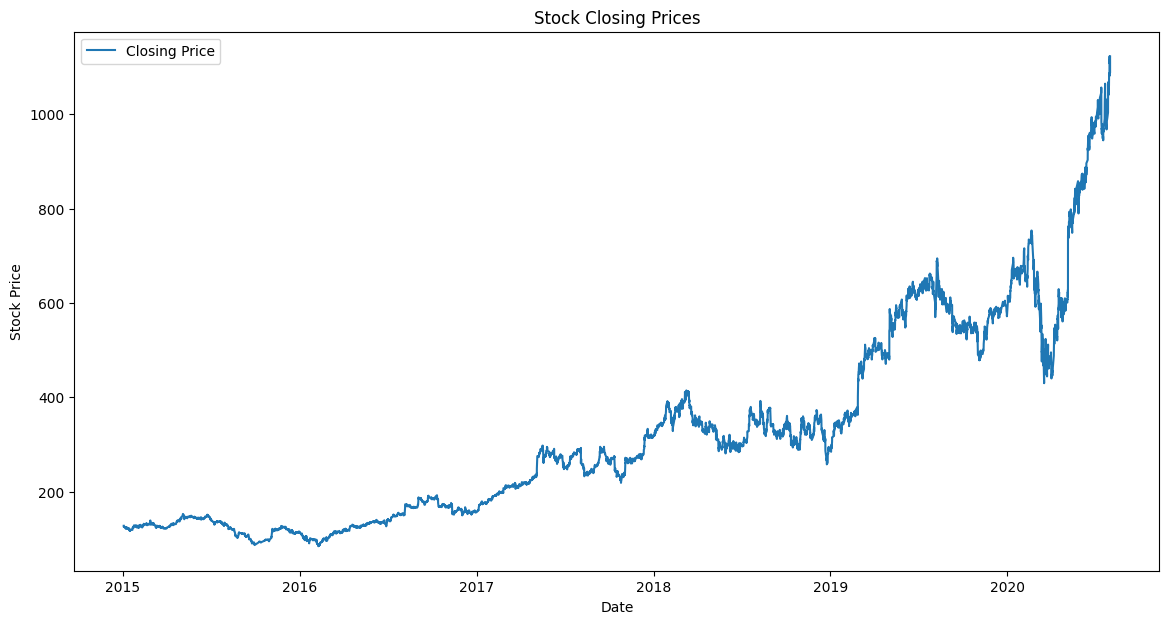

In [14]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(14, 7))
plt.plot(df_mercado_stock['close'], label='Closing Price')
plt.title('Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [15]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data

merged_data = pd.merge(df_mercado_stock, df_mercado_trends, left_index=True, right_index=True, how='inner')

# Verify the merged data
merged_data.head()


# View the first and last five rows of the DataFrame
display(merged_data.head())
display(merged_data.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6
2016-06-01 10:00:00,136.63,12
2016-06-01 11:00:00,136.56,22
2016-06-01 12:00:00,136.42,33
2016-06-01 13:00:00,136.10,40


,close,Search Trends
2020-07-31 11:00:00,1105.780,20
2020-07-31 12:00:00,1087.925,32
2020-07-31 13:00:00,1095.800,41
2020-07-31 14:00:00,1110.650,47
2020-07-31 15:00:00,1122.510,53


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

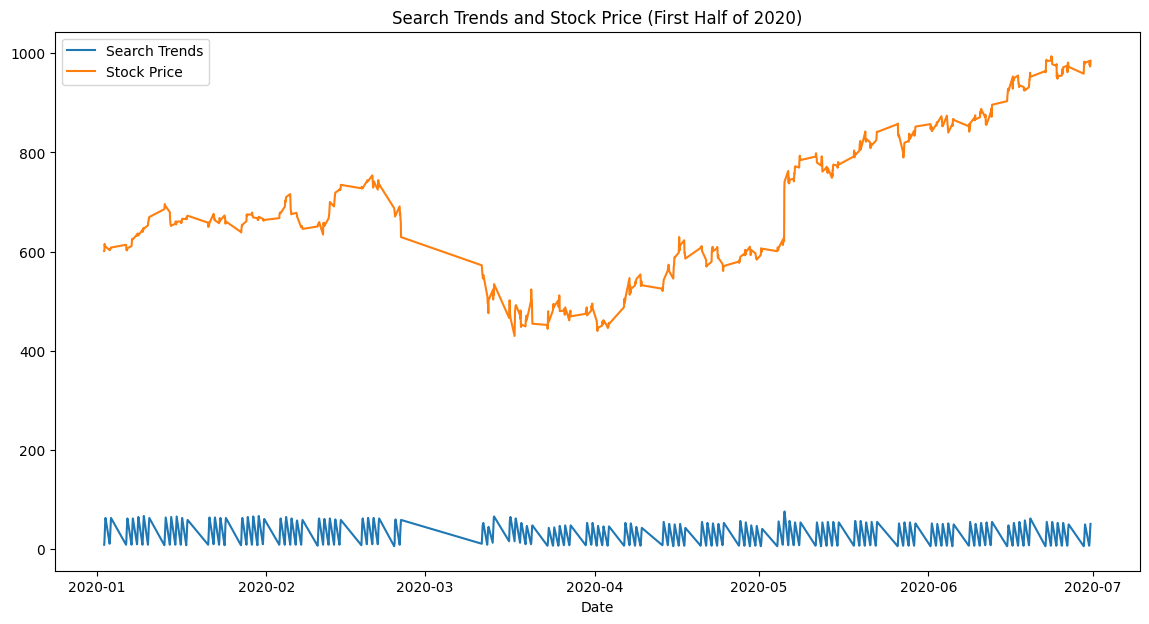

,close,Search Trends
2020-01-02 09:00:00,601.085,9
2020-01-02 10:00:00,601.290,14
2020-01-02 11:00:00,615.410,25
2020-01-02 12:00:00,611.400,37
2020-01-02 13:00:00,611.830,50


,close,Search Trends
2020-06-30 11:00:00,976.17,17
2020-06-30 12:00:00,977.50,27
2020-06-30 13:00:00,973.23,37
2020-06-30 14:00:00,976.50,45
2020-06-30 15:00:00,984.93,51


In [16]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020_data = merged_data.loc['2020-01':'2020-06']

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(first_half_2020_data['Search Trends'], label='Search Trends')
plt.plot(first_half_2020_data['close'], label='Stock Price')
plt.title('Search Trends and Stock Price (First Half of 2020)')
plt.xlabel('Date')
plt.legend()
plt.show()

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020_data.head())
display(first_half_2020_data.tail())


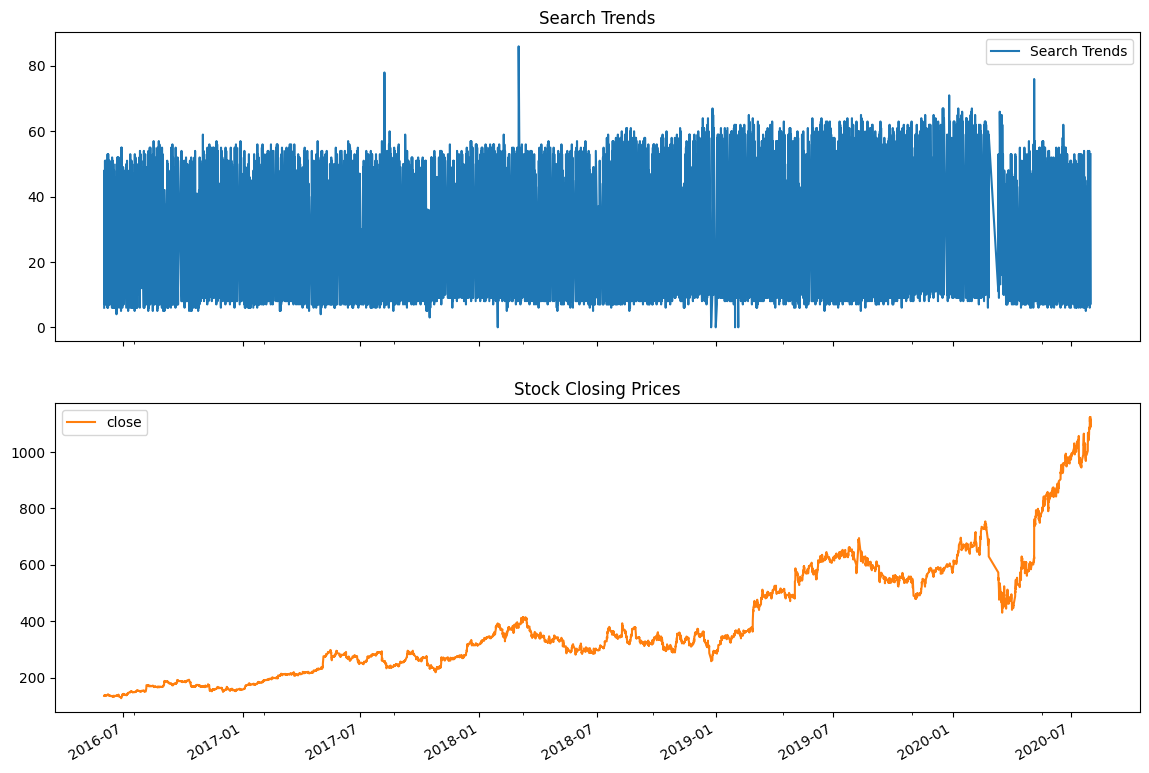

In [17]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
# Merge search data and stock data
merged_data = pd.merge(df_mercado_stock, df_mercado_trends, left_index=True, right_index=True, how='inner')

# Plot each column on a separate axes using subplots=True
axes = merged_data[['Search Trends', 'close']].plot(subplots=True, figsize=(14, 10), title=['Search Trends', 'Stock Closing Prices'])

# Display the plots
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**
Based on the below chart, there is very small correlation between Search trends and Stock price

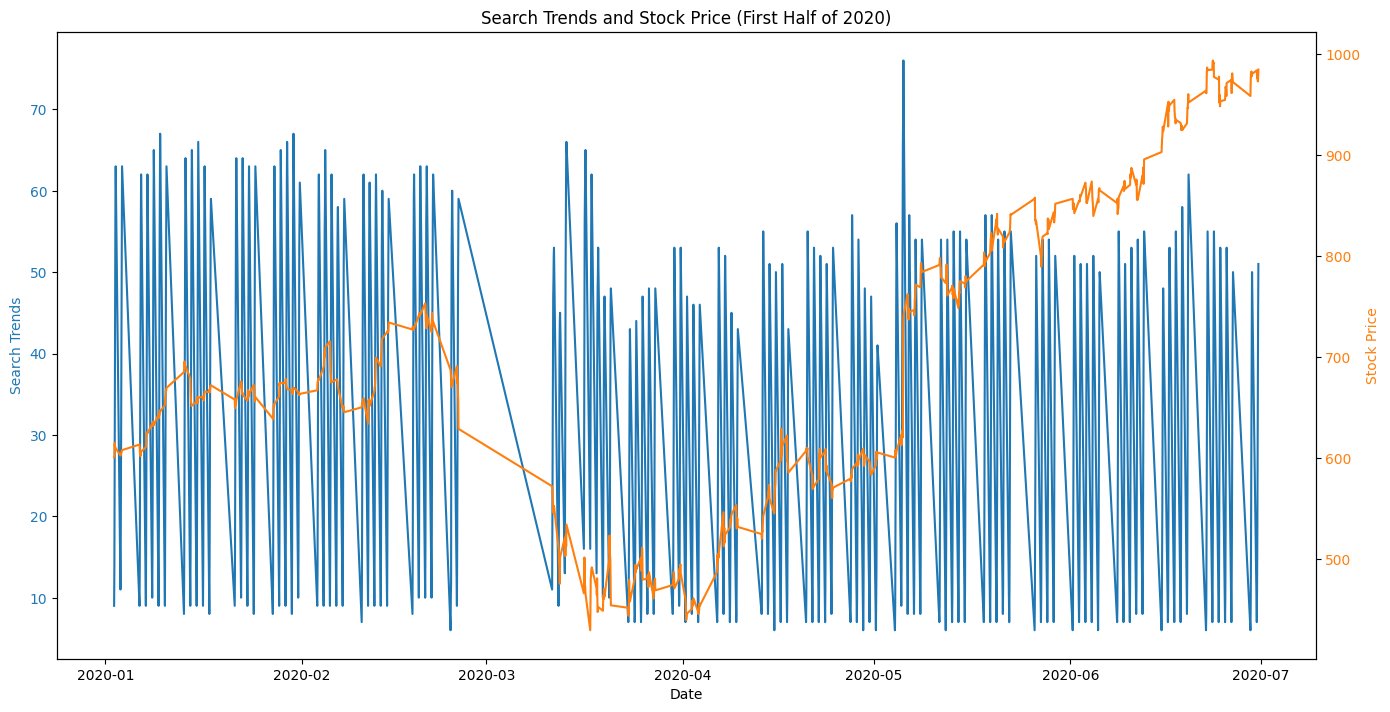

,Search Trends,close
Search Trends,1.000000,-0.011475
close,-0.011475,1.000000


In [18]:
first_half_2020_data = merged_data.loc['2020-01':'2020-06']
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Search Trends', color='tab:blue')
ax1.plot(first_half_2020_data.index, first_half_2020_data['Search Trends'], color='tab:blue', label='Search Trends')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Stock Price', color='tab:orange')
ax2.plot(first_half_2020_data.index, first_half_2020_data['close'], color='tab:orange', label='Stock Price')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Search Trends and Stock Price (First Half of 2020)')
plt.show()
#find the correlation
correlation = first_half_2020_data[['Search Trends', 'close']].corr()
correlation

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

merged_data['Lagged Search Trends'] = merged_data['Search Trends'].shift(1)

In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

merged_data['Stock Volatility'] = merged_data['close'].pct_change().rolling(window=4).std().ewm(span=4).mean()

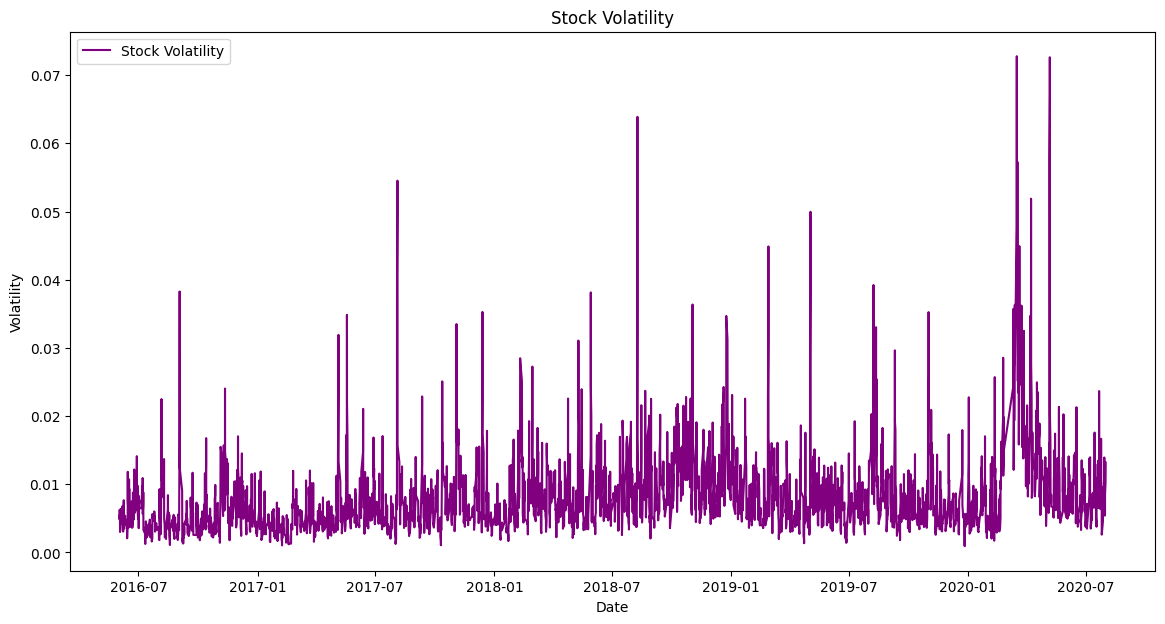

In [21]:
# Visualize the stock volatility
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Stock Volatility'], label='Stock Volatility', color='purple')
plt.title('Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [22]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

merged_data['Hourly Stock Return'] = merged_data['close'].pct_change()

In [23]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(merged_data.head())
display(merged_data.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20,11.0,0.011976,0.006380
2020-07-31 12:00:00,1087.925,32,20.0,0.012605,-0.016147
2020-07-31 13:00:00,1095.800,41,32.0,0.012881,0.007239
2020-07-31 14:00:00,1110.650,47,41.0,0.012929,0.013552
2020-07-31 15:00:00,1122.510,53,47.0,0.013184,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [24]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
merged_data[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.101543,0.030849
Lagged Search Trends,-0.101543,1.000000,0.017929
Hourly Stock Return,0.030849,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**

Based on the chart below,
**Lagged Search Trends and Stock Volatility**: There is no strong linear relationship. The weak negative correlation suggests that changes in lagged search trends do not significantly predict changes in stock volatility.

**Lagged Search Trends and Hourly Stock Return**: There is no strong linear relationship. The very weak positive correlation suggests that changes in lagged search trends do not significantly predict changes in hourly stock returns.

**Stock Volatility and Hourly Stock Return**: There is no strong linear relationship. The very weak positive correlation suggests that changes in stock volatility do not significantly predict changes in hourly stock returns.

Correlation Matrix:
                      Lagged Search Trends  Stock Volatility  \
Lagged Search Trends              1.000000         -0.101543   
Stock Volatility                 -0.101543          1.000000   
Hourly Stock Return               0.017929          0.030849   

                      Hourly Stock Return  
Lagged Search Trends             0.017929  
Stock Volatility                 0.030849  
Hourly Stock Return              1.000000  


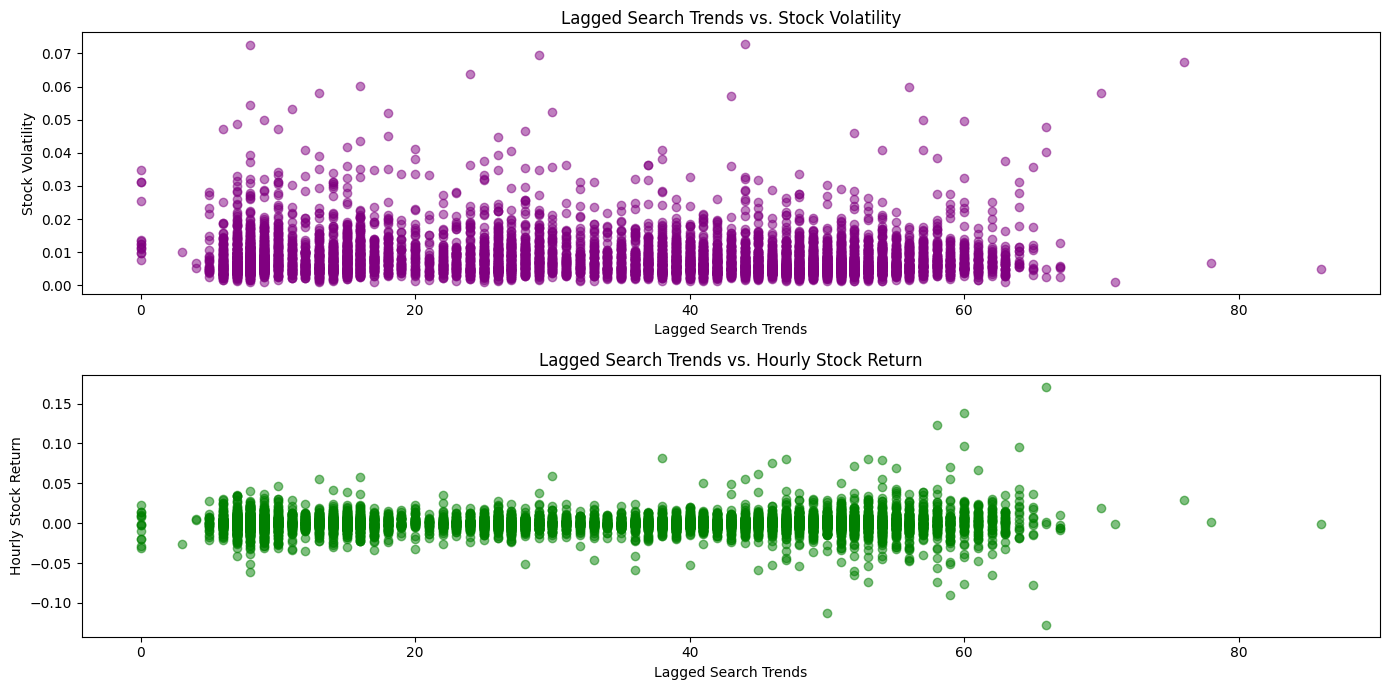

In [25]:
correlation_matrix = merged_data[['Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].corr()
print("Correlation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.scatter(merged_data['Lagged Search Trends'], merged_data['Stock Volatility'], alpha=0.5, color='purple')
plt.title('Lagged Search Trends vs. Stock Volatility')
plt.xlabel('Lagged Search Trends')
plt.ylabel('Stock Volatility')

plt.subplot(2, 1, 2)
plt.scatter(merged_data['Lagged Search Trends'], merged_data['Hourly Stock Return'], alpha=0.5, color='green')
plt.title('Lagged Search Trends vs. Hourly Stock Return')
plt.xlabel('Lagged Search Trends')
plt.ylabel('Hourly Stock Return')

plt.tight_layout()
plt.show()

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [26]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index


# Label the columns ds and y so that the syntax is recognized by Prophet


# Drop an NaN values from the prophet_df DataFrame


# View the first and last five rows of the mercado_prophet_df DataFrame


# Reset the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Rename the columns for Prophet
mercado_prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'}, inplace=True)

# Drop any NaN values
mercado_prophet_df.dropna(inplace=True)

# View the first and last five rows
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [27]:
# Call the Prophet function, store as an object
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(mercado_prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/shcsb6fs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/04hwp31o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56168', 'data', 'file=/tmp/tmp7qij7w6d/shcsb6fs.json', 'init=/tmp/tmp7qij7w6d/04hwp31o.json', 'output', 'file=/tmp/tmp7qij7w6d/prophet_modele89o47b_/prophet_model-20240731020559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
# Fit the time-series model.


In [29]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame


In [30]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame


# Display the first five rows of the forecast_mercado_trends DataFrame
# Create future dataframe for forecasting
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')  # Forecasting 2000 hours ahead (approx 80 days)

# View the last five rows of the future_mercado_trends DataFrame


display(future_mercado_trends.tail())


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


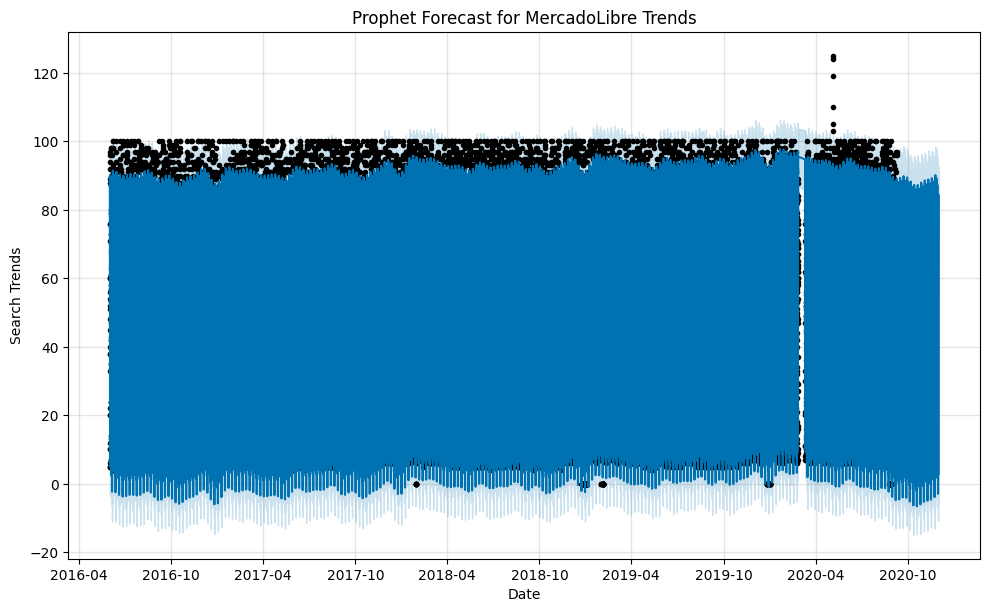

                       ds       yhat  yhat_lower  yhat_upper
39058 2020-11-28 09:00:00   3.695713   -4.568996   12.177504
39059 2020-11-28 10:00:00   9.886566    0.901174   18.646926
39060 2020-11-28 11:00:00  18.683776    9.770162   27.588801
39061 2020-11-28 12:00:00  28.190746   20.103639   37.201505
39062 2020-11-28 13:00:00  36.626974   27.877330   45.299254
39063 2020-11-28 14:00:00  42.888639   34.063666   51.221792
39064 2020-11-28 15:00:00  46.764736   38.642692   55.285431
39065 2020-11-28 16:00:00  48.751992   39.997189   57.743863
39066 2020-11-28 17:00:00  49.731123   41.082070   58.114450
39067 2020-11-28 18:00:00  50.770582   42.000770   59.248803
39068 2020-11-28 19:00:00  53.028115   45.095331   61.048208
39069 2020-11-28 20:00:00  57.482437   49.086589   66.538553
39070 2020-11-28 21:00:00  64.361588   55.419294   73.253603
39071 2020-11-28 22:00:00  72.555612   63.999119   81.106219
39072 2020-11-28 23:00:00  79.571971   70.851047   88.265812
39073 2020-11-29 00:00:0

In [31]:
# Plot the Prophet predictions for the Mercado trends data
forecast = model.predict(future_mercado_trends)
fig1 = model.plot(forecast)
plt.title('Prophet Forecast for MercadoLibre Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.show()

# View the forecast DataFrame
forecast.tail()
# View the last five rows of the forecast DataFrame
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Analyze the near-term forecast
near_term_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(48)  # View the next 48 hours
print(near_term_forecast)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**

Increasing Trend:

The forecast indicates a general increase in the search trend for MercadoLibre over the upcoming days, reaching a peak around mid-day and evening hours.
Highs and Lows:

The yhat values show that the search popularity is predicted to fluctuate, with higher values typically during daytime and lower values during early morning hours.
For instance, the values start at 3.695713 on 2020-11-28 09:00:00 and peak at 84.488006 on 2020-11-30 00:00:00 before showing a slight decrease again.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/i72kkqku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/avlwcgvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22187', 'data', 'file=/tmp/tmp7qij7w6d/i72kkqku.json', 'init=/tmp/tmp7qij7w6d/avlwcgvp.json', 'output', 'file=/tmp/tmp7qij7w6d/prophet_modelmisse_g_/prophet_model-20240731021802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


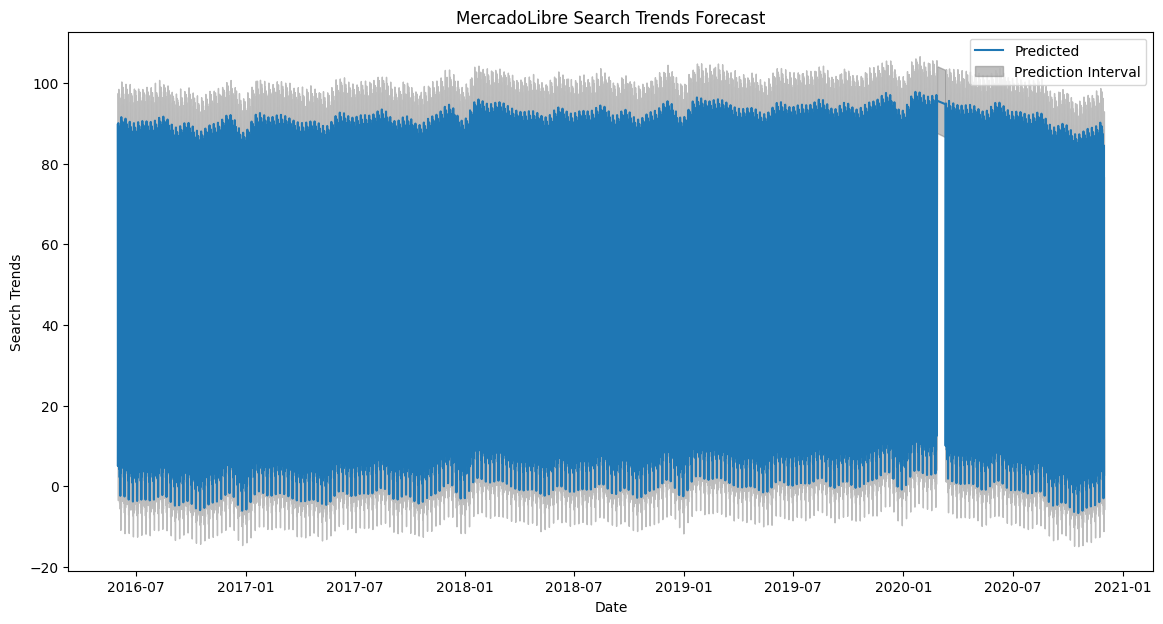

In [38]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column

mercado_prophet_df = df_mercado_trends.reset_index()
mercado_prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'}, inplace=True)

# Drop any NaN values
mercado_prophet_df.dropna(inplace=True)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(mercado_prophet_df)

# Create future dataframe for forecasting
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')  # Forecasting 2000 hours ahead (approx 80 days)

# Estimate the model and predict the future values
forecast = model.predict(future_mercado_trends)

# Ensure 'ds' column is present by resetting the index of the forecast
forecast.reset_index(drop=False, inplace=True)

# View only the yhat, yhat_lower, and yhat_upper columns from the DataFrame
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Set the index in the forecast_filtered DataFrame to the ds datetime column
forecast_filtered.set_index('ds', inplace=True)




Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [33]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.figure(figsize=(14, 7))
plt.plot(forecast_filtered.index, forecast_filtered['yhat'], label='Predicted')
plt.fill_between(forecast_filtered.index, forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='gray', alpha=0.5, label='Prediction Interval')
plt.title('MercadoLibre Search Trends Forecast')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

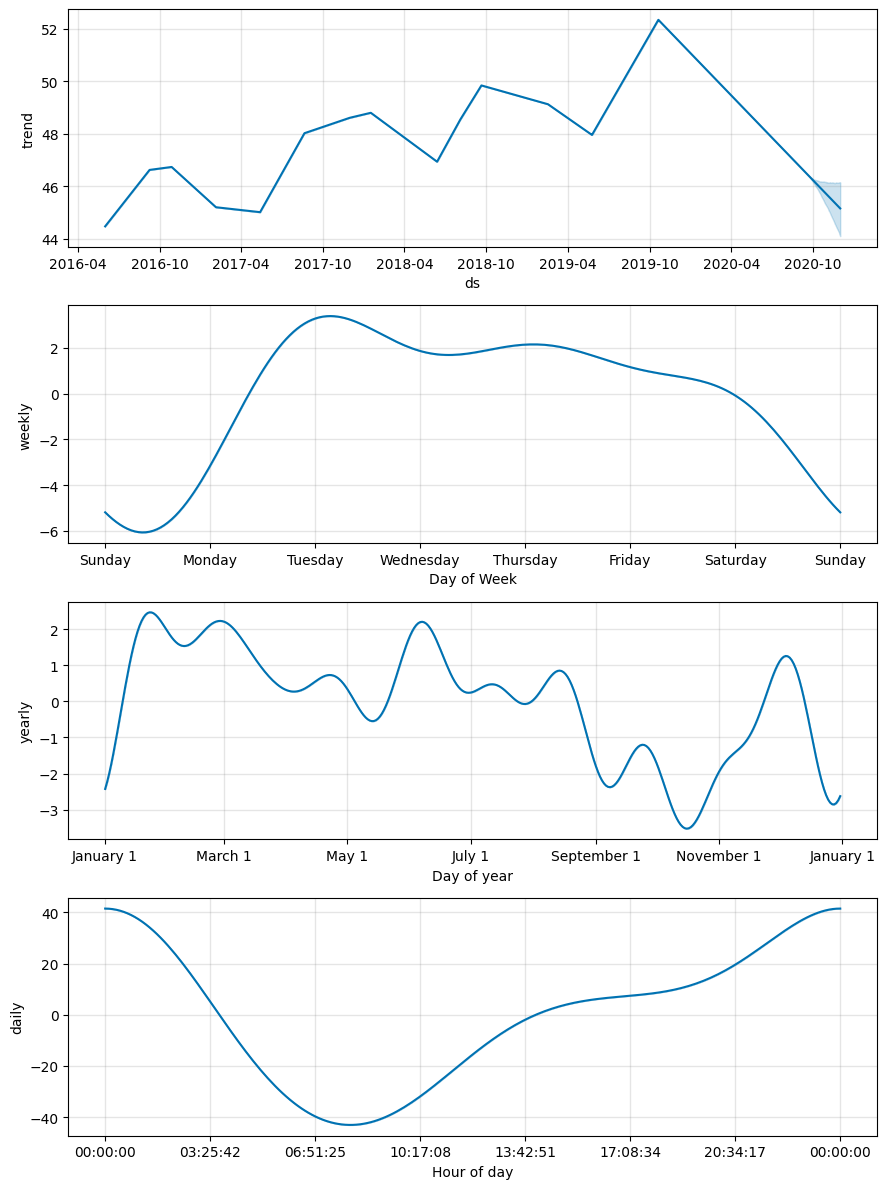

In [39]:
# Reset the index in the forecast_mercado_trends DataFrame


# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
forecast = model.predict(future_mercado_trends)

# Reset the index in the forecast DataFrame to ensure 'ds' is a column
forecast.reset_index(drop=False, inplace=True)

# Plot the individual time series components
fig2 = model.plot_components(forecast)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**

00:00:00 is the most popular

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/_p1hpub9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7qij7w6d/yso1lju4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57852', 'data', 'file=/tmp/tmp7qij7w6d/_p1hpub9.json', 'init=/tmp/tmp7qij7w6d/yso1lju4.json', 'output', 'file=/tmp/tmp7qij7w6d/prophet_model3_j5kw22/prophet_model-20240731022643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:26:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:27:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Time of day with the greatest popularity: 0
Mean yhat value at this time: 89.37724004444664


**Question:** Which day of week gets the most search traffic?
   
**Answer:**

 Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**

September midweek
